In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import requests


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Team 55 [NEW]/Data/FEMA_cleaned/IndividualsAndHouseholdsProgramValidRegistrations_katOnly.csv", low_memory=False)

In [4]:
df.sample(5)

,incidentType,declarationDate,disasterNumber,county,damagedStateAbbreviation,damagedCity,damagedZipCode,applicantAge,householdComposition,occupantsUnderTwo,...,repairAmount,replacementAssistanceEligible,replacementAmount,personalPropertyEligible,personalPropertyAmount,ihpMax,haMax,onaMax,lastRefresh,id
491535,Hurricane,2005-08-29T00:00:00.000Z,1603,East Baton Rouge (Parish),LA,BATON ROUGE,70811.0,35-49,2,0,...,0.0,0,0.0,0,0.0,0,0,0,2022-11-21T23:34:39.000Z,f84360ef-883f-4db5-968a-b043db6b6920
128996,Hurricane,2005-08-29T00:00:00.000Z,1603,St. Tammany (Parish),LA,COVINGTON,70433.0,35-49,1,0,...,0.0,0,0.0,0,0.0,0,0,0,2022-11-21T23:34:39.000Z,6f92168e-d0f7-4e18-ba14-9cf11e8fda73
258771,Hurricane,2005-08-29T00:00:00.000Z,1603,Jefferson (Parish),LA,KENNER,70065.0,35-49,4,0,...,0.0,0,0.0,0,0.0,0,0,0,2022-11-21T23:34:39.000Z,f5ef428d-2a59-4bc4-9279-46a5438d8ac3
206193,Hurricane,2005-08-29T00:00:00.000Z,1603,St. Bernard (Parish),LA,CHALMETTE,70043.0,50-64,2,0,...,0.0,0,0.0,0,0.0,0,0,0,2022-11-21T23:34:39.000Z,4517f360-0bc7-4db1-9a36-ca230e7f3562
776907,Hurricane,2005-08-29T00:00:00.000Z,1603,Orleans (Parish),LA,NEW ORLEANS,70119.0,19-34,1,0,...,0.0,0,0.0,0,0.0,0,0,0,2022-11-21T23:34:39.000Z,974f4249-1c90-472a-a14d-26befd7ab0e4


In [5]:
#Pull all 'NEW ORLEANS' from the damagedCity column. Some 'NEW ORLEANS' neighborhoods also fall in other Parishes but for this part of the analysis we'll only pull 'Orleans (Parish)' from the county column. 
#The Data Center Research tables available to us include population by neighborhoods within New Orleans. We hope to match these neigborhoods to a zip code(s) sourced from The Data Center. 
#https://www.datacenterresearch.org/maps/reference-maps/#gallery-4
#damagedZipCode may contain a couple of errors or NaNs?
##Select zip codes within Orleans Parish. We'll use The Data Center zip codes. (There were still some from other counties appearing and even some potentially out of state zip codes.)

new_orleans_city = df[(df['damagedCity']=='NEW ORLEANS')][(df['county']=='Orleans (Parish)')]

new_orleans_city['damagedZipCode'] = new_orleans_city['damagedZipCode'].astype('Int64', errors='ignore')

no_zipcodes = 70112, 70113, 70114, 70115, 70116, 70117, 70118, 70119, 70122, 70124, 70125, 70126, 70127, 70128, 70129, 70130, 70131

new_new_orleans_city = new_orleans_city[new_orleans_city['damagedZipCode'].isin(no_zipcodes)]

new_orleans = new_new_orleans_city.reset_index(drop=True)


<ipython-input-5-d5bea14d1bcf>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_orleans_city = df[(df['damagedCity']=='NEW ORLEANS')][(df['county']=='Orleans (Parish)')]


In [6]:
##group by zip codes 
##then identify which neighborhood within New Orleans those zip codes belong to
##create visual (bar graph maybe?) of the number of registrations per zip code/neiborhood(if possible)
##further break down the registrations by just those that were 'ihpEligible'(boolean column)
##we can also analyse the reasons why registrant may have been ineligible for haAmount by looking at haStatus
#does being ineligible for haStatus mean the registrant was also ineligible for onaAmount and that registrant received 0? Will investigate

zip_codes_grouped = new_new_orleans_city.groupby(['damagedZipCode']).size()

zip_codes_grouped

#the zip codes not starting with '7' are questionable
#Even after removing all parishes except Orleans, there are some zip codes from other counties
#Could compile list of zip codes and pull those?



damagedZipCode
70112     5394
70113     9062
70114    19640
70115    28193
70116    13710
70117    43031
70118    29149
70119    36378
70122    34030
70124    15772
70125    19210
70126    31479
70127    22638
70128    14597
70129     9966
70130    13259
70131    17278
dtype: int64

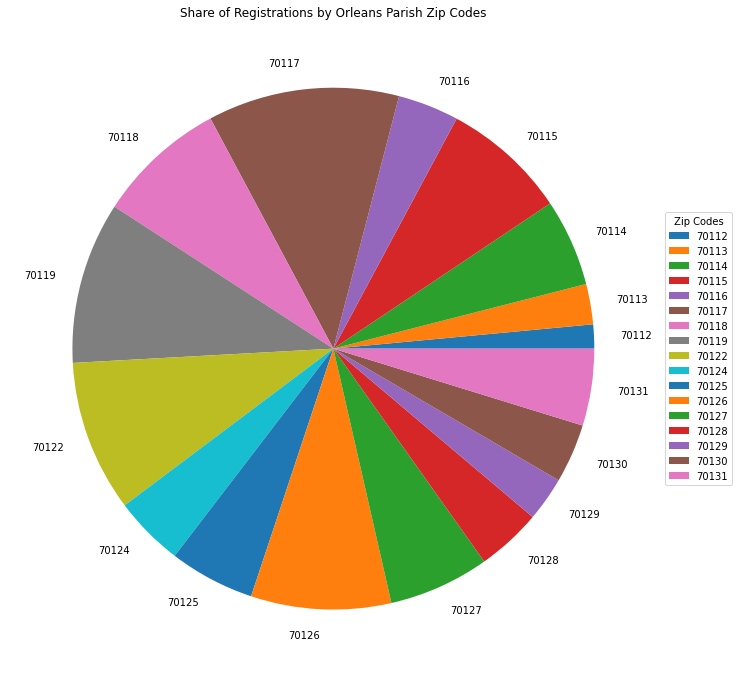

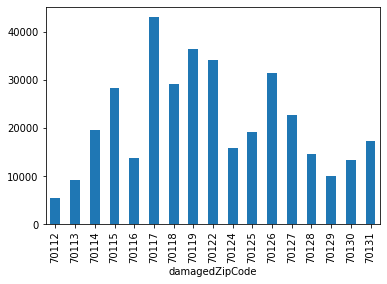

In [7]:
##Pie chart of registrations within Orleans Parish

zipcodes =  '70112', '70113', '70114', '70115', '70116', '70117', '70118', '70119', '70122', '70124', '70125', '70126', '70127', '70128', '70129', '70130', '70131'


fig = plt.figure(figsize =(15, 12))
plt.pie(zip_codes_grouped, labels = zipcodes)

plt.legend( zipcodes,
          title ="Zip Codes",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.title("Share of Registrations by Orleans Parish Zip Codes")
plt.show()

zip_codes_grouped.plot.bar()
plt.show()

## Next step: plot only ihp eligible. eligible + ha status reflecting registrant received aid


In [8]:
##In order to better analyze the distribution of aid amongst income ranges, it is necessary to parse 
unique_values = new_new_orleans_city['haStatus'].value_counts().reset_index()
ha_received = ["ER - Eligible - Rental Assistance", "408-CLC", "ENC - Eligible - No change on appeal, original eligible status stands", "EAH - Eligible - Expedited Housing Assistance", "ERFD - Eligible - Readily Fabricated Dwelling", "ERPLZ - Eligible Replacement Housing, Flood Insurance Required", "ERPL - Eligible Replacement Housing", "EHR - Eligible - Home Repairs", "ERCT - Eligible - Recertification", "EHRZ - Eligible - Home Repairs, Flood Insurance Required", "TSAI - Transitional Shelter Assistance Information", "ETR - Eligible - Transient Housing", "ERFI - Eligible - Rental, Flood Insurance", "ERSUPP - Eligible - Recertification Supplement", "ERIA - Eligible - Inaccessible", "ERU - Eligible - Utilities Out", "ENCOMP - Eligible - Two months non-compliance", "EAHA - Eligible - Accelerated Housing Assistance", "ECR - Eligible - Created Resources", "EHRS - Eligible - Home Repair SBA Referral"]    
ha_received

['ER - Eligible - Rental Assistance',
 '408-CLC',
 'ENC - Eligible - No change on appeal, original eligible status stands',
 'EAH - Eligible - Expedited Housing Assistance',
 'ERFD - Eligible - Readily Fabricated Dwelling',
 'ERPLZ - Eligible Replacement Housing, Flood Insurance Required',
 'ERPL - Eligible Replacement Housing',
 'EHR - Eligible - Home Repairs',
 'ERCT - Eligible - Recertification',
 'EHRZ - Eligible - Home Repairs, Flood Insurance Required',
 'TSAI - Transitional Shelter Assistance Information',
 'ETR - Eligible - Transient Housing',
 'ERFI - Eligible - Rental, Flood Insurance',
 'ERSUPP - Eligible - Recertification Supplement',
 'ERIA - Eligible - Inaccessible',
 'ERU - Eligible - Utilities Out',
 'ENCOMP - Eligible - Two months non-compliance',
 'EAHA - Eligible - Accelerated Housing Assistance',
 'ECR - Eligible - Created Resources',
 'EHRS - Eligible - Home Repair SBA Referral']

In [9]:
#create new column for updated amounts of housing assistance received ('actual_ha')
#create new column for updated amount of ihp assistance (actual ha + ona amounts)


def ha_function(x, y):
  ha_received = ["ER - Eligible - Rental Assistance", "408-CLC", "ENC - Eligible - No change on appeal, original eligible status stands", "EAH - Eligible - Expedited Housing Assistance", "ERFD - Eligible - Readily Fabricated Dwelling", "ERPLZ - Eligible Replacement Housing, Flood Insurance Required", "ERPL - Eligible Replacement Housing", "EHR - Eligible - Home Repairs", "ERCT - Eligible - Recertification", "EHRZ - Eligible - Home Repairs, Flood Insurance Required", "TSAI - Transitional Shelter Assistance Information", "ETR - Eligible - Transient Housing", "ERFI - Eligible - Rental, Flood Insurance", "ERSUPP - Eligible - Recertification Supplement", "ERIA - Eligible - Inaccessible", "ERU - Eligible - Utilities Out", "ENCOMP - Eligible - Two months non-compliance", "EAHA - Eligible - Accelerated Housing Assistance", "ECR - Eligible - Created Resources", "EHRS - Eligible - Home Repair SBA Referral"]    

  if x in ha_received:
    return y
  else:
    return 0

new_orleans['actual_ha'] = new_orleans.apply(lambda x: ha_function(x['haStatus'], x['haAmount']), axis= 1)

print(new_orleans.loc[:,['haStatus','haAmount', 'actual_ha']])


#new_orleans2 = new_orleans.loc[new_orleans['haStatus'].isin(ha_received) & (new_orleans['ihpEligible']==1)]

#new_orleans2.head(5)

                                                 haStatus  haAmount  actual_ha
0                       ER - Eligible - Rental Assistance    6767.0     6767.0
1                              No Longer in 403 Agreement    1352.0        0.0
2                                                 408-CLC    4358.0     4358.0
3                                                 408-CLC    6149.0     6149.0
4         INSS - Ineligible - No substantiation submitted    4172.0        0.0
...                                                   ...       ...        ...
362781                  ER - Eligible - Rental Assistance    4358.0     4358.0
362782                                                NaN       0.0        0.0
362783  INC - Ineligible - No change on appeal, origin...    2000.0        0.0
362784           INP - Ineligible - Not Primary Residence       0.0        0.0
362785      EAH - Eligible - Expedited Housing Assistance    2000.0     2000.0

[362786 rows x 3 columns]


In [10]:
new_orleans['actual_ihp'] = new_orleans['actual_ha'] + new_orleans['onaAmount']

print(new_orleans.loc[:,['haStatus','haAmount', 'actual_ha', 'ihpAmount','actual_ihp']])


                                                 haStatus  haAmount  \
0                       ER - Eligible - Rental Assistance    6767.0   
1                              No Longer in 403 Agreement    1352.0   
2                                                 408-CLC    4358.0   
3                                                 408-CLC    6149.0   
4         INSS - Ineligible - No substantiation submitted    4172.0   
...                                                   ...       ...   
362781                  ER - Eligible - Rental Assistance    4358.0   
362782                                                NaN       0.0   
362783  INC - Ineligible - No change on appeal, origin...    2000.0   
362784           INP - Ineligible - Not Primary Residence       0.0   
362785      EAH - Eligible - Expedited Housing Assistance    2000.0   

        actual_ha  ihpAmount  actual_ihp  
0          6767.0    6767.00     6767.00  
1             0.0    1352.00        0.00  
2          4358.0 

In [11]:
fig = px.box(new_orleans, x='grossIncome', y='actual_ihp', color='ownRent', color_discrete_sequence= px.colors.sequential.Plasma )
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

fig.update_xaxes(categoryorder='array', categoryarray= ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'])

fig.update_layout(xaxis_title="Self Reported Income", yaxis_title="Dollar Amount Approved")

fig.update_layout(title='Revised Distribution of IHP Aid Approved by Income Range')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
#this take too long on large datasets
from uszipcode import SearchEngine

def get_city(zipcode):
  engine = SearchEngine()
  zipcode = engine.by_zipcode(zipcode)
  return zipcode.city


ModuleNotFoundError: ignored

In [ ]:
##This was pointless and it took too long. Didn't actually work. All zip codes would come back as New Orleans anyway. 
#new_new_orleans_city['city'] = new_new_orleans_city['damagedZipCode'].apply(get_city)

#new_new_orleans_city
zipcode = engine.by_zipcode(70115)
print(zipcode.city)


##

##
## **OLD EXPLORATORY ANALYSIS WORK AFTER THIS POINT**

In [ ]:
df["grossIncome"]

In [ ]:
df["id"].nunique()

In [ ]:
#self reported grossIncome for individuals

gross_income = df.groupby(['grossIncome']).size()



In [ ]:
gross_income 

In [ ]:
order = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']
gross_income.loc[order].plot.bar( rot=90 )
plt.title("Individuals And Households Program Valid Registrations Gross Income")
plt.xlabel('Self Reported Gross Income') 
plt.ylabel('Count') 
plt.show()



In [ ]:
#gross income broken out by owner/renter/unknown
#Should unknowns be taken out?
#What do unknowns mean here? Information not given? or not applicable?  

# For program registrants with incomes <$30,000, more are renters. For program registrants with incomes >$30,001, more are owners.

gross_income_rent_own_status = df.groupby(['grossIncome', 'ownRent']).size()

df_a = gross_income_rent_own_status.to_frame().reset_index()

plt.figure(figsize=(14,10))
ax = sns.barplot(data= df_a, x='grossIncome', y=0 , hue='ownRent', order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='husl' )
ax.axes.set_title("Individuals And Households Program Valid Registrations Gross Income \nOwner vs Renter", fontsize=16)
ax.set_xlabel("Self Reported Income", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(title='Owner-Rental Status', loc='upper left')


plt.show()

In [ ]:
#skip this table
#skip this table
#skip this table
#owners grouped by income and by HOMEOWNERS insurance status
#homeOwnersInsurance column is boolean, 1=insurance 0=no insurance
#Almost all income ranges have more owners with homeowners insurance than not except for '<$15,000'

owners_with_homeowners_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'homeOwnersInsurance']).size() 

order = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']
owners_with_homeowners_insurance.loc[order].plot.bar( rot=90, color=['y', 'm'] )
plt.title("Individuals And Households Program Valid Registrations Gross Income: \nOwners with Homeowners Insurance")
plt.xlabel('Homeowners Insurance Status by Self Reported Gross Income') 
plt.ylabel('Count') 
plt.show()




In [ ]:
#skip this table
#skip this table
#skip this table
#owners grouped by income and by FLOOD insurance status
#homeOwnersInsurance column is boolean, 1=insurance 0=no insurance 


owners_with_flood_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'floodInsurance']).size() 

order = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']



owners_with_flood_insurance.loc[order].plot.bar( rot=90, color=['y', 'm'] )
plt.title("Individuals And Households Program Valid Registrations Gross Income: \nOwners with Flood Insurance")
plt.xlabel('Flood Insurance Status by Self Reported Gross Income') 
plt.ylabel('Count') 


plt.show()


In [ ]:
#same as tables above but using sns 
#was not able to correctly modify legend

owners_with_homeowners_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'homeOwnersInsurance']).size() 
df_b = owners_with_homeowners_insurance.to_frame().reset_index()

plt.figure(figsize=(14,10))
ax = sns.barplot(data= df_b, x='grossIncome', y=0 , hue='homeOwnersInsurance', order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='OrRd' )
ax.axes.set_title("Individuals and Households Program Valid Registrations Gross Income: \nOwners with Homeowners Insurance", fontsize=16)
ax.set_xlabel("Self Reported Income", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(title='Homeowners Insurance', loc='upper left')


plt.show()


In [ ]:
owners_with_flood_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'floodInsurance']).size() 
df_c = owners_with_flood_insurance.to_frame().reset_index()

plt.figure(figsize=(14,10))
ax = sns.barplot(data= df_c, x='grossIncome', y=0 , hue='floodInsurance', order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='OrRd' )
ax.axes.set_title("Individuals and Households Program Valid Registrations Gross Income: \nOwners with Flood Insurance", fontsize=16)
ax.set_xlabel("Self Reported Income", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(title='Flood Insurance', loc='upper left')


plt.show()




In [ ]:
#seaborn.FacetGrid for homeowners insurance and flood insurance
#I wanted to plot the same data as above but I think the simpler bar plots in the previous cells produce better visuals. This format might stretch out the distributions a bit too much
#scratch these
#scratch these
#scratch these


owners_with_homeowners_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'homeOwnersInsurance']).size()
order = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']


df1 = owners_with_homeowners_insurance.to_frame().reset_index()
grid = sns.FacetGrid(df1, col='grossIncome', col_order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], height=5)
grid.map_dataframe(sns.barplot, x='homeOwnersInsurance', y= 0, palette='ocean_r')


owners_with_flood_insurance = df[df['ownRent'] =='Owner'].groupby(['grossIncome', 'floodInsurance']).size()
order = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']


df1 = owners_with_flood_insurance.to_frame().reset_index()
grid = sns.FacetGrid(df1, col='grossIncome', col_order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], height=5)
grid.map_dataframe(sns.barplot, x='floodInsurance', y= 0, palette= 'ocean_r')


In [ ]:
#boxplot of dollar amounts received by owners 

df['haAmount'] = df['haAmount'].astype(float)

df_dropZero = df


print("Amount that received 0 aid:" , df_dropZero[df_dropZero["haAmount"] == 0 ]["haAmount"].count())

df_dropZero = df_dropZero[df_dropZero["haAmount"] > 0]

print("minval:", df_dropZero["haAmount"].min())

print(df.columns)


ihp_amounts_for_owners = df_dropZero[df_dropZero['ownRent'] =='Owner'] 



plt.figure(figsize=(22,8))
boxplot = sns.boxplot(data= ihp_amounts_for_owners, x=ihp_amounts_for_owners['grossIncome'],y=ihp_amounts_for_owners['haAmount'], order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='husl', width=0.3);

boxplot.axes.set_title("Distribution of IHP Aid Approved by Income Range for OWNERS", fontsize=16)
boxplot.set_xlabel("Self Reported Income", fontsize=14)
boxplot.set_ylabel("Dollar Amount Approved", fontsize=14)

plt.show()






In [ ]:
#boxplot of dollar amounts received by renters 

ihp_amounts_for_renters = df[df['ownRent'] =='Renter'] 
ihp_amounts_for_renters

plt.figure(figsize=(22,8))
boxplot = sns.boxplot(data=ihp_amounts_for_renters, x=ihp_amounts_for_renters['grossIncome'], y=ihp_amounts_for_renters['ihpAmount'], order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='husl', width=0.3);

boxplot.axes.set_title("Distribution of IHP Aid Approved by Income Range for RENTERS", fontsize=16)
boxplot.set_xlabel("Self Reported Income", fontsize=14)
boxplot.set_ylabel("Dollar Amount Approved", fontsize=14)

plt.show()




In [ ]:

sns.set_theme(style="ticks", palette="pastel")

plt.figure(figsize=(22,10))
ax = sns.boxplot(x='grossIncome', y='ihpAmount', hue='ownRent' , data=df, order=['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'], palette='Set3')

ax.axes.set_title("Distribution of IHP Aid Approved by Income Range", fontsize=16)
ax.set_xlabel("Self Reported Income", fontsize=14)
ax.set_ylabel("Dollar Amount Approved", fontsize=14)



plt.show()









In [ ]:
#BOXPLOT WITH PLOTLY





fig = px.box(df, x='grossIncome', y='ihpAmount', color='ownRent', color_discrete_sequence= px.colors.sequential.Plasma )
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

fig.update_xaxes(categoryorder='array', categoryarray= ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000'])

fig.update_layout(xaxis_title="Self Reported Income", yaxis_title="Dollar Amount Approved")

fig.update_layout(title='Distribution of IHP Aid Approved by Income Range')

fig.show()




In [ ]:
#distribution for renters
gross_income_vals = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']

for income in gross_income_vals:
  ihp_renter = ihp_amounts_for_renters[ihp_amounts_for_renters["grossIncome"] == income]
  ihp_renter = ihp_renter[["grossIncome","ihpAmount"]]

  ax = sns.histplot(data= ihp_renter["ihpAmount"], bins = 100)
  title = "renters grossIncome of " + income + ", ihpAmount distribution"

  ax.set_title(title)

  plt.show()

In [ ]:

#distribution for home owners

gross_income_vals = ['0','<$15,000','$15,000-$30,000','$30,001-$60,000','$60,001-$120,000','$120,001-$175,000','>$175,000']

for income in gross_income_vals:
  ihp_owner = ihp_amounts_for_owners[ihp_amounts_for_owners["grossIncome"] == income]
  ihp_owner = ihp_owner[["grossIncome","ihpAmount"]]

  ax = sns.histplot(data= ihp_owner["ihpAmount"], bins = 100)
  title = "owners grossIncome of " + income + ", ihpAmount distribution"

  ax.set_title(title)

  plt.show()